Gabriel Marcelino, Grant Burk, and Eli Kaustinen <br>
November 2024 <br>
GAN-Based Application <br>

## Problem Statement


The purpose of this project is to design a GAN-based application using Keras and TensorFlow that can generate fake images that look like real ones. The main idea is to train a GAN with a mix of real and fake images so it can learn to distinguish (discriminate) between them.


## Import Required Libraries

In [9]:
## Kernel dies, not generating good images
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt



## Preprocess data

In [10]:
def load_images(image_dir, img_size=(28, 28)):
    """
    Load images with progress bar and detailed logging
    """
    if not os.path.exists(image_dir):
        raise ValueError(f"Directory '{image_dir}' does not exist!")
    
    # Get list of files first
    image_files = [f for f in os.listdir(image_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    total_files = len(image_files)
    print(f"Found {total_files} image files in directory")
    
    images = []
    for i, img_name in enumerate(tqdm(image_files, desc="Loading images")):
        try:
            if i == 0:  # Print info about first image
                img_path = os.path.join(image_dir, img_name)
                original_size = os.path.getsize(img_path) / 1024  # Size in KB
                print(f"\nFirst image size: {original_size:.2f} KB")
                
            img_path = os.path.join(image_dir, img_name)
            img = image.load_img(img_path, target_size=img_size, color_mode='rgb')
            img = img_to_array(img)
            img = (img - 127.5) / 127.5
            images.append(img)
                
        except Exception as e:
            print(f"\nError loading {img_name}: {str(e)}")
            continue
    
    if not images:
        raise ValueError("No images were successfully loaded!")
    
    final_array = np.array(images)
    print(f"\nFinal dataset shape: {final_array.shape}")
    return final_array

# Test the loading
try:
    print("Current working directory:", os.getcwd())
    print("\nStarting image loading...")
    
    # Time the loading process
    start_time = time.time()
    
    x_tr = load_images('portraits')
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"\nLoading completed in {duration:.2f} seconds")
    print(f"Number of images loaded: {len(x_tr)}")
    print(f"Data shape: {x_tr.shape}")
    print(f"Memory usage: {x_tr.nbytes / (1024 * 1024):.2f} MB")
    
except Exception as e:
    print(f"Error during loading: {str(e)}")

Current working directory: /Users/gabriel/Desktop/GAN

Starting image loading...
Found 6512 image files in directory


Loading images:   0%|          | 0/6512 [00:00<?, ?it/s]


First image size: 126.71 KB


Loading images: 100%|██████████| 6512/6512 [01:50<00:00, 58.90it/s] 



Final dataset shape: (6512, 28, 28, 3)

Loading completed in 110.82 seconds
Number of images loaded: 6512
Data shape: (6512, 28, 28, 3)
Memory usage: 58.43 MB


## Build Generator

In [11]:
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, input_dim=input_dim),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model


## Build Discriminator

In [12]:
def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, input_dim=input_dim),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


## Build GAN (Stack Generator and Discriminator)

In [13]:
def build_gan(generator, discriminator, input_dim):
    model = tf.keras.Sequential([
        generator,
        discriminator
    ])
    return model


## Train GAN

In [14]:
def train_step(generator, discriminator, gan, x_train, batch_size, input_dimension):
    # Get random real samples
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]
    
    # Ensure real images are properly shaped
    real_images = real_images.reshape(batch_size, -1)
    
    # Generate fake samples
    noise = np.random.normal(0, 1, (batch_size, input_dimension))
    fake_images = generator.predict(noise, verbose=0)
    
    # Combine real and fake images
    x = np.concatenate([real_images, fake_images])
    y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    # Add random noise to labels for smoothing
    y += 0.05 * np.random.random(y.shape)
    
    # Train discriminator
    discriminator.trainable = True
    d_metrics = discriminator.train_on_batch(x, y)
    d_loss = d_metrics[0] if isinstance(d_metrics, list) else d_metrics
    
    # Train generator
    noise = np.random.normal(0, 1, (batch_size * 2, input_dimension))
    y_gan = np.ones((batch_size * 2, 1))
    discriminator.trainable = False
    g_metrics = gan.train_on_batch(noise, y_gan)
    g_loss = g_metrics[0] if isinstance(g_metrics, list) else g_metrics
    
    return float(d_loss), float(g_loss)


## Function to plot generated images to track progress

In [ ]:
def plot_generated_images(epoch, generator, input_dimension, examples=25, dim=(5, 5), figsize=(6, 6)):
    """Plot generated images in a compact grid"""
    noise = np.random.normal(0, 1, size=[examples, input_dimension])
    generated_images = generator.predict(noise, verbose=0)
    
    # Reshape and rescale the images
    generated_images = generated_images.reshape(-1, 28, 28, 3)
    generated_images = (generated_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]
    
    # Plot the images
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(pad=0.5)  # Add padding between figure edges and subplots
    plt.show()
    plt.close()



: 

## Run Training Loop 

Training Progress:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0/400 [D loss: 0.9157] [G loss: 0.9157]


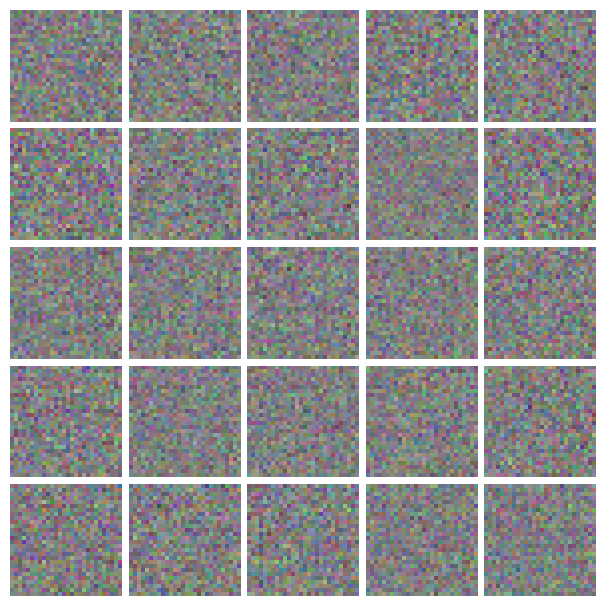

Training Progress:   3%|▎         | 11/400 [02:48<1:30:54, 14.02s/it]

Epoch 10/400 [D loss: 0.2818] [G loss: 0.2818]


Training Progress:   5%|▌         | 21/400 [05:03<1:26:27, 13.69s/it]

Epoch 20/400 [D loss: 0.1656] [G loss: 0.1656]


Training Progress:   8%|▊         | 31/400 [07:44<1:36:09, 15.64s/it]

Epoch 30/400 [D loss: 0.0847] [G loss: 0.0847]


Training Progress:  10%|█         | 41/400 [10:29<1:34:35, 15.81s/it]

Epoch 40/400 [D loss: -0.0069] [G loss: -0.0069]


Training Progress:  12%|█▎        | 50/400 [13:43<2:05:39, 21.54s/it]

Epoch 50/400 [D loss: -0.1012] [G loss: -0.1012]


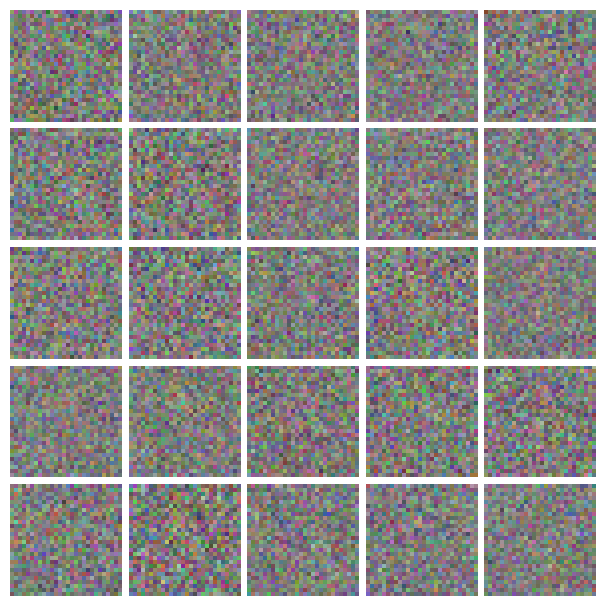

Training Progress:  15%|█▌        | 61/400 [18:17<2:32:42, 27.03s/it]

Epoch 60/400 [D loss: -0.1252] [G loss: -0.1252]


Training Progress:  18%|█▊        | 71/400 [20:15<1:05:48, 12.00s/it]

Epoch 70/400 [D loss: -0.0704] [G loss: -0.0704]


Training Progress:  20%|██        | 81/400 [22:31<1:13:46, 13.88s/it]

Epoch 80/400 [D loss: -0.0083] [G loss: -0.0083]


Training Progress:  22%|██▎       | 90/400 [24:54<1:24:06, 16.28s/it]

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Training setup
input_dimension = 100
img_dimension = 28 * 28 * 3
batch_size = 32
epochs = 400
plot_interval = 50

def preprocess_images(images):
    """Preprocess images to have consistent dimensions"""
    # If images are in shape (batch, height, width, channels)
    # Reshape to (batch, flattened_dimension)
    if len(images.shape) == 4:
        return images.reshape(images.shape[0], -1)
    return images

def train(x_train, epochs=400, batch_size=32):
    # Preprocess the entire training dataset
    x_train = x_train.reshape(x_train.shape[0], -1)
    
    d_losses, g_losses = [], []
    
    # Initialize tqdm progress bar
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        d_loss, g_loss = train_step(generator, discriminator, gan, x_train, batch_size, input_dimension)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]')
        
        if epoch % plot_interval == 0:
            plot_generated_images(epoch, generator, input_dimension)
    
    return d_losses, g_losses


# Training setup
input_dimension = 100
img_dimension = 28 * 28 * 3
batch_size = 32
epochs = 400
plot_interval = 50

# Build and compile models with separate optimizers
generator = build_generator(input_dimension, img_dimension)
discriminator = build_discriminator(img_dimension)

# Create separate optimizer instances
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Compile discriminator
discriminator.compile(
    optimizer=discriminator_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build GAN
discriminator.trainable = False
gan = build_gan(generator, discriminator, input_dimension)
gan.compile(
    optimizer=generator_optimizer,
    loss='binary_crossentropy'
)
discriminator.trainable = True

# Train the GAN
d_losses, g_losses = train(x_tr, epochs=epochs, batch_size=batch_size)


## References
https://kaushiklade27.medium.com/image-generation-using-generative-adversarial-networks-gans-cd82afd71597